In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## **Context**
----------------------------------------------------------------------------------

Text Summarization is the task of extracting the gist of a lengthy document in the form of a summary. There's a lot of subjectivity around what represents a good summary versus what's a poor summary. The subjectivity largely revolves around whether the entire context contained in the larger document has been extracted and is conveyed by the summary of the same. But machines of course do not work on subjectivity. Therefore, we need to train models that play their part in understanding Natural Language, and only then will our models be able learn to produce outputs that to our corresponding inputs can encapsulate the entire message in shorter text.

Document Summarizers have found a lot of use, for example, in stock brokerage websites that can show us news in short regarding particular stocks. This will help traders who trade based on fundamental analysis. Summarizers can also help in summarizing threads of conversations in several messaging services, for example, in Google Workspace. This way, one can be updated about progress in their workspaces for example, without having to spend a lot of time in going through the threads.

--------------------------------------------------------------------------------------

## **Problem Statement**

-------------------------------------------------------------------------------------
The objective of this project is to build a Sequential NLP model which is trained to summarize long sentences to produce shorter texts that efficiently encapsulate meaning.

-------------------------------------------------------------------------------------

## **Dataset**

----------------------------------------------------------------------------------------------
WikiHow is a large-scale dataset using the online WikiHow (http://www.wikihow.com/) knowledge base.

The features of this dataset are:

- **headline**: Bold lines as summary
- **title**: A one-line header about the purpose of the text article
- **text**: The text article itself

### **Loading the dataset**
- Extract "wikihow-summarization.zip"
- Read "wikihowAll.csv"

In [ ]:
#!unzip "/content/drive/MyDrive/Datasets/wikihow-summarization.zip"
!unzip "/content/drive/MyDrive/Colab Notebooks/wikihow-summarization.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/wikihow-summarization.zip
  inflating: wikihowAll.csv          


In [ ]:
import pandas as pd
df = pd.read_csv('wikihowAll.csv')

In [ ]:
df.head()

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


### **Dropping null values**
- To preprocess the text we need to drop null values first

In [ ]:
df.dropna(how='any',axis=0, inplace=True)
df.drop_duplicates(subset=['text'],inplace=True)
df.shape

(209178, 3)

### **Preprocess Text**
Preprocess values of the text & headline columns:

- Remove unwanted characters
- Convert text to lowercase
- Remove unwanted spaces
- Remove stopwords
- Replace empty strings with Null
- Drop null values from the dataframe

In [ ]:
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def preprocess_text(df, column_name=''):

  # Select only alphabets
  df[column_name] = df[column_name].apply(lambda x: re.sub('[^a-zA-Z0-9_ \n\.]', '', x))


  # Convert text to lowercase
  df[column_name] = df[column_name].apply(lambda x: x.lower())

  # Strip unwanted spaces
  df[column_name] = df[column_name].apply(lambda x: x.strip())

  # Remove stopwords
  df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

  # Replace empty strings with Null
  df[column_name].replace('', np.nan, inplace = True)

  # Drop Null values
  df = df.dropna()

  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Use the `preprocess_text` function on the text and headline column:

In [ ]:
df = preprocess_text(df, column_name='headline')
df = preprocess_text(df, column_name='text')

### **Adding the START and END token at the beginning and end of the headline**

In [ ]:
df['headline'] = df['headline'].apply(lambda x : 'sostok '+ x + ' eostok')

### **Printing some rows from the text and headline columns**

### **Get the length of each headline and text and add a column for that**

In [ ]:
df['len_headline'] = df['headline'].apply(lambda x: len(x.split(" ")))
df['len_text'] = df['text'].apply(lambda x: len(x.split(" ")))
df.head()

,headline,title,text,len_headline,len_text
0,sostok keep related supplies area. make effort...,How to Be an Organized Artist1,youre photographer keep necessary lens cords b...,60,343
1,sostok create sketch neopoprealist manner futu...,How to Create a Neopoprealist Art Work,see image drawing develops stepbystep. however...,76,347
2,sostok get bachelors degree. enroll studiobase...,How to Be a Visual Effects Artist1,possible become vfx artist without college deg...,29,252
3,sostok start experience interest art. understa...,How to Become an Art Investor,best art investors research pieces art buy som...,73,470
4,sostok keep reference materials sketches artic...,How to Be an Organized Artist2,start planning project work youll likely gathe...,39,241


In [ ]:
df.shape

(208940, 5)

In [ ]:
#df['len_headline'] = df['headline'].apply(lambda x: len(x.split(" ")))
#df['len_text'] = df['text'].apply(lambda x: len(x.split(" ")))
#df.head()

### **Check the distribution of data**
- This will help us in deciding the maximum length

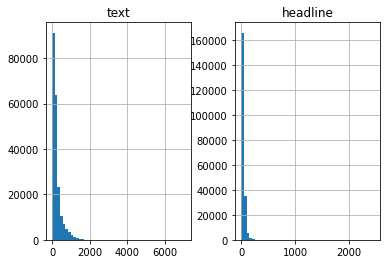

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
headline_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
  text_word_count.append(len(i.split()))

for i in df['headline']:
  headline_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'headline':headline_word_count})
length_df.hist(bins = 50)
plt.show()

### **Let's check the percentage of headlines below 80 words**

In [ ]:
cnt=0
for i in df['headline']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(df['headline']))

0.9273427778309563


### **Let's check the percentage of text below 600 words**

In [ ]:
cnt=0
for i in df['text']:
    if(len(i.split())<=600):
        cnt=cnt+1
print(cnt/len(df['text']))

0.9134679812386332


### **For reducing data, we'll take headings where length > 50 and text where length > 100**

In [ ]:
df = df[(df.len_headline >50) & (df.len_text >100)]
df.shape

(33005, 5)

### **Train test split**

Split the dataset into train and test set with a 80% to 20% ratio.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text, df.headline, test_size = 0.2, random_state=42)

#del df why delete the df?

### **Print one sample**

In [ ]:
# text
X_train[0]

'youre photographer keep necessary lens cords batteries quadrant home studio. paints kept brushes cleaner canvas print supplies ink etc. make broader groups areas supplies make finding easier limiting search much smaller area. ideas include essential supplies area things use every day. inspiration reference area. dedicated work area . infrequent secondary supplies area tucked way. doesnt mean cleaning entire studio means keeping area immediately around desk easel pottery wheel etc. clean night. discard trash unnecessary materials wipe dirty surfaces. endeavor leave workspace way sit next day start working immediately without work tidying. even rest studio bit disorganized organized workspace help get business every time want make art. visual people lot artist clutter comes desire keep track supplies visually instead tucked sight. using jars old glasses vases cheap clear plastic drawers keep things sight without leaving strewn haphazardly. ideas beyond mentioned include canvas shoe rack

In [ ]:
# headline
y_train[0]

'sostok keep related supplies area. make effort clean dedicated workspace every session. place loose supplies large clearly visible containers. use clotheslines clips hang sketches photos reference material. use every inch room storage especially vertical space. use chalkboard paint make space drafting ideas right walls. purchase label maker make organization strategy semipermanent. make habit throwing old excess useless stuff month. eostok'

### **Initialize parameter values**
- Set values for max_features, maxlen
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence

In [ ]:
max_features = 10000
maxlen_headline = 50
maxlen_text = 100

### **Applying the `tensorflow.keras` Tokenizer and getting indices for words**
- Initialize Tokenizer object with number of words as 10000
- Fit different tokenizer objects on headline and text column
- Convert the text to sequence


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

feature_tokenizer = Tokenizer(num_words= 10000)
feature_tokenizer.fit_on_texts(X_train)
X_train = feature_tokenizer.texts_to_sequences(X_train)
X_test = feature_tokenizer.texts_to_sequences(X_test)

print("Number of Samples in X_train:", len(X_train))       
print(X_train[0])

label_tokenizer = Tokenizer(num_words=max_features)
label_tokenizer.fit_on_texts(y_train)
y_train = label_tokenizer.texts_to_sequences(y_train)
y_test = label_tokenizer.texts_to_sequences(y_test)

print("Number of Samples in y_train:", len(y_train))       
print(y_train[0])

Number of Samples in X_train: 26404
[2027, 280, 215, 1634, 198, 413, 2, 421, 215, 22, 4380, 198, 13, 281, 20, 7, 39, 324, 163, 2210, 198, 4, 385, 20, 695, 879, 369, 585, 125, 45, 2071, 585, 46, 1573, 5138, 1356, 1804, 410, 163, 23, 85, 183, 6889, 1104, 407, 5333, 2474, 369, 2044, 1567, 406, 813, 3918, 71, 1916, 2522, 2384, 7648, 16, 1813, 139, 2224, 240, 139, 103, 874, 76, 764, 7221, 317, 8150, 1513, 3918, 1, 61, 75, 1026, 20, 423, 109, 330, 75, 3006, 754, 1755, 151, 1621, 119, 80, 122, 1025, 153, 608, 1182, 2499, 28, 87, 61, 331, 395, 736, 100, 1772, 222, 166, 1996, 174, 266, 53, 210, 307, 436, 56, 4293, 129, 174, 78, 8, 7648, 522, 887, 7648, 1996, 39, 324, 4859, 6540, 1848, 4859, 107, 7064, 4293, 78, 8, 1804, 410, 4, 1848, 1996, 283, 98, 2429, 4555, 4211, 395, 36, 6, 390, 174, 650, 10, 136, 9, 231, 42, 4294, 4771, 174, 4574, 508, 7648, 1996, 462, 19, 225, 245, 16, 610, 406, 183, 6889, 2, 14, 4007, 3406, 75, 4293, 1996, 283, 5383, 1036, 42, 1014, 1089, 503, 607, 2621, 5, 233, 1463, 13

### **Pad sequences**
- Pad each example in the 'post' configuration according to the maximum lengths for text and headlines respectively.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = maxlen_text, padding='post')
X_test = pad_sequences(X_test, maxlen = maxlen_text, padding='post')

y_train = pad_sequences(y_train, maxlen = maxlen_headline, padding='post')
y_test = pad_sequences(y_test, maxlen = maxlen_headline, padding='post')

### **Vocab mapping**

Note: There is no word at the 0th index

In [ ]:
feature_tokenizer.word_index

{'may': 1,
 'make': 2,
 'use': 3,
 'also': 4,
 'need': 5,
 'get': 6,
 'one': 7,
 'time': 8,
 'want': 9,
 'like': 10,
 'dont': 11,
 'youre': 12,
 'help': 13,
 'sure': 14,
 'take': 15,
 'people': 16,
 'keep': 17,
 'try': 18,
 'good': 19,
 'work': 20,
 'find': 21,
 'even': 22,
 'way': 23,
 'might': 24,
 'water': 25,
 'go': 26,
 'look': 27,
 'youll': 28,
 'you': 29,
 'see': 30,
 'example': 31,
 'using': 32,
 'place': 33,
 'back': 34,
 'many': 35,
 'first': 36,
 'well': 37,
 'know': 38,
 'two': 39,
 'feel': 40,
 'it': 41,
 'new': 42,
 'much': 43,
 'around': 44,
 'ask': 45,
 'give': 46,
 'right': 47,
 'start': 48,
 'best': 49,
 'person': 50,
 'could': 51,
 'day': 52,
 'something': 53,
 'things': 54,
 'important': 55,
 'add': 56,
 'different': 57,
 'would': 58,
 'hair': 59,
 'small': 60,
 'able': 61,
 'information': 62,
 'however': 63,
 'top': 64,
 'include': 65,
 'side': 66,
 'think': 67,
 'long': 68,
 'often': 69,
 'must': 70,
 'set': 71,
 'put': 72,
 'body': 73,
 'used': 74,
 'avoid': 75,


In [ ]:
label_tokenizer.word_index

{'sostok': 1,
 'eostok': 2,
 'make': 3,
 'use': 4,
 'get': 5,
 'take': 6,
 'add': 7,
 'find': 8,
 'click': 9,
 'dont': 10,
 'place': 11,
 'water': 12,
 'time': 13,
 'keep': 14,
 'one': 15,
 'look': 16,
 'consider': 17,
 'go': 18,
 'choose': 19,
 'want': 20,
 'try': 21,
 'know': 22,
 'check': 23,
 'start': 24,
 'select': 25,
 'create': 26,
 'sure': 27,
 'using': 28,
 'set': 29,
 'new': 30,
 'remove': 31,
 'right': 32,
 'open': 33,
 'like': 34,
 'cut': 35,
 'back': 36,
 'top': 37,
 'ask': 38,
 'work': 39,
 'first': 40,
 'learn': 41,
 'avoid': 42,
 'put': 43,
 'need': 44,
 'two': 45,
 'around': 46,
 'hair': 47,
 'good': 48,
 'apply': 49,
 'understand': 50,
 'see': 51,
 'tap': 52,
 'decide': 53,
 'clean': 54,
 'youre': 55,
 'give': 56,
 'determine': 57,
 'side': 58,
 'you': 59,
 'it': 60,
 'help': 61,
 'let': 62,
 'people': 63,
 'area': 64,
 'file': 65,
 '1': 66,
 'paper': 67,
 'enter': 68,
 'small': 69,
 'prepare': 70,
 '2': 71,
 'day': 72,
 'plan': 73,
 'dry': 74,
 'talk': 75,
 'type': 7

### **Set number of words**
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [ ]:
num_words_text = len(feature_tokenizer.word_index) + 1
print(num_words_text)

num_words_headline = len(label_tokenizer.word_index) + 1
print(num_words_headline)

173962
64266


### **Delete rows that contain only START and END token**

In [ ]:
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

### **Building our Model**
- We'll use an Encoder-Decoder architecture here
- We shall define an Input with shape (maxlen_text, )
- Then we shall add an Embedding layer
- Going forward, we shall add our encoder LSTM layers
- Here we are using Teacher Forcing, so therefore, the decoder LSTMs shall externally receive Target Inputs
- Then a decoder Dense layer shall produce final Output from the Time Distributed Outputs of decoder LSTMs


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow import keras

hidden_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(maxlen_text, ))

# Embedding layer
enc_emb =  Embedding(num_words_text, embedding_dim, trainable=True)(encoder_inputs) 

# Encoder lstm 1
encoder_lstm1 = LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder lstm 2
encoder_lstm2 = LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder lstm 3
encoder_lstm3 = LSTM(hidden_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(num_words_headline, embedding_dim, trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(num_words_headline, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs) 

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     17396200    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

### **Compile the model**
- use optimizer as 'rmsprop'
- use loss as 'sparse_categorical_crossentropy'

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### **Add Callbacks**

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

### **Fit the mode**l
- Training will take some time

In [30]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=20, callbacks=[es], batch_size=96,
                    validation_data=([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/20
276/276 [==============================] - 351s 1s/step - loss: 8.5804 - val_loss: 8.1481
Epoch 2/20
276/276 [==============================] - 310s 1s/step - loss: 8.0862 - val_loss: 8.1075
Epoch 3/20
276/276 [==============================] - 306s 1s/step - loss: 8.0564 - val_loss: 8.0887
Epoch 4/20
276/276 [==============================] - 302s 1s/step - loss: 8.0307 - val_loss: 8.0657
Epoch 5/20
276/276 [==============================] - 301s 1s/step - loss: 8.0147 - val_loss: 8.0470
Epoch 6/20
276/276 [==============================] - 301s 1s/step - loss: 8.0051 - val_loss: 8.0296
Epoch 7/20
276/276 [==============================] - 300s 1s/step - loss: 7.9978 - val_loss: 8.0187
Epoch 8/20
276/276 [==============================] - 302s 1s/step - loss: 7.9889 - val_loss: 8.0455
Epoch 9/20
276/276 [==============================] - 301s 1s/step - loss: 7.9818 - val_loss: 8.0082
Epoch 10/20
276/276 [==============================] - 300s 1s/step - loss: 8.0288 - val_lo

### **Plot the results**

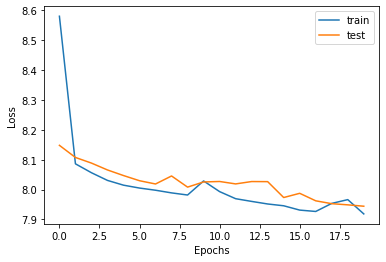

In [31]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

### **Dictionary to Convert Index to word**

In [32]:
reverse_target_word_index = label_tokenizer.index_word
reverse_source_word_index = feature_tokenizer.index_word
target_word_index = label_tokenizer.word_index

### **Inference**
- In Inference Stage, we shall not be using Teacher forcing. We shall re use the output of previous decoder timestep which becomes the input of the next timestep.

In [33]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_hidden_state_input = Input(shape=(maxlen_text, hidden_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]) #dec_emb2

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Function to implement inference

In [34]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) + 2
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (maxlen_headline-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

## **Features to text**
- Add functions to get text back from encoded text and headline

In [35]:
def seq2headline(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [36]:
for i in range(0,10):
    print("Text:",seq2text(X_train[i]))
    print("Original headline:", seq2headline(y_train[i]))
    print("Predicted headline:", decode_sequence(X_train[i].reshape(1, maxlen_text)))
    print("\n")

Text: behind brain come associate pain time cause mentally shy away using bad words youre really serious method could give permission friend preferably one prone little snap band you try remember agreed it time could boss innocent little son daughter long someone youd ashamed swear front of whenever swear visualize standing beside expression face help deter you many peoples habits especially teenagers influenced explicit content much favorite music movies t v shows feel like case youre sound like favorite may need reality check remind people speak real world try switching radio station pop music least download clean versions favorite songs instead 
Original headline: them use swear jar the swear jar method helped many people kick habit ping wrist rubber band this method human equivalent putting electric shock collar dog eliminate bad behaviors effective pretend always within another way train bite tongue whenever feel swear word coming imagine someone listening avoid music media 
1/1 [

Nothing Here

**OBSERVATIONS**:  
* This model generates a very high number of trainable parameters (57MM plus), thus utilizing a lot of compute power.  
* The original **dataset** (text and headlines) seems to be missing stopwords, thus the sentences do not read comprehensibly.  
* **Increasing the size of the dataset** -We took only 10k points due to computational constraints. If we have high-end GPUs available this model can be trained on a much bigger dataset thereby improving the results.
* Since we stopped the training after only a few epocs, the training loss is still decreasing. Therefore, the model's performance would increase if allowed to train further.  
* **Use of Bidirectional LSTMs**- We discussed earlier that for Encoder decoder with the attention we make use of Bidirectional LSTMs. However we built our model with unidirectional LSTM.

**RECOMMENDATIONS:**  
* Train the model over many more epocs, but using a vocab including all stopwords.  
* Train a model with more points, which would take more processing time.  
* Perhaps train the model with a max summary words of 50 or less for ease of understanding long documents, but with the understanding that the fewer the max summary words, the worse the model will do at predicting correctly.